# 🚀 Analyse des Consommations Énergétique en Bretagne

## **Contexte**
Dans ce projet, nous analysons les données liées aux logements en Bretagne pour mieux comprendre leur consommation énergétique et identifier des pistes d'amélioration. L'objectif est d'évaluer les coûts énergétiques et leur relation avec les caractéristiques des logements.



## **1. Étapes de l'Analyse**

### **1.1. Préparation des Données**
- **Chargement des données** :
  - `logements_neufs.csv` : Données des nouveaux logements.
  - `logements_existants.csv` : Données des logements existants.
  
  

In [1]:
import pandas as pd
import os

logements_neufs = pd.read_csv('data/raw/neufs.csv')
logements_existants = pd.read_csv('data/raw/existents.csv')

C:\Users\Evidya\AppData\Local\Temp\ipykernel_19044\2368810878.py:4: DtypeWarning: Columns (80,100,111,112,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_neufs = pd.read_csv('data/raw/neufs.csv')
C:\Users\Evidya\AppData\Local\Temp\ipykernel_19044\2368810878.py:5: DtypeWarning: Columns (159,191,202,208,214,215,218,219,220,221,228,232) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_existants = pd.read_csv('data/raw/existents.csv')


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
print(logements_neufs.shape)
print(logements_existants.shape)

(59213, 135)
(398114, 235)


On peut remarquer que les datasets contiennent énormément de données et de variables. Nous avons supprimé les variables contenant beaucoup de données manquantes, 

La colonne **Logement** a été ajouté aux dataframes pour distinguer les logements existants des neufs. Nous avons aussi remarqué que les logements neufs ne disposent pas de la colonne **Année_cnstruction** que nous pensons utile pour la modélisation.



In [4]:
logements_neufs["Date_réception_DPE"] = pd.to_datetime(logements_neufs["Date_réception_DPE"], errors='coerce')
logements_neufs["Année_construction"] = logements_neufs["Date_réception_DPE"].apply(lambda x : x.year)

In [45]:
import os
from mapping import generate_map

df = pd.read_csv(os.path.join("data","processed","data_map.csv"), sep=";", encoding="utf-8-sig")

generate_map(df.sample(10000))

Nous avons fusionné les deux datasets en fonction des colonnes communes. En ce qui concerne la modélisation prédictive, les choix des colonnes ce sont portées sur les suivantes:

In [5]:
cols_kept = ['Année_construction',
            'Code_postal_(brut)',
            'Coût_total_5_usages',
            'Etiquette_DPE',
            'Etiquette_GES',
            'Hauteur_sous-plafond',
            'Logement',
            'Nombre_niveau_logement',
            'Surface_habitable_logement',
            'Type_bâtiment',
            'N°_département_(BAN)']

Nous les avons prétraité au travers la fonction **quali_quanti_preprocessing**. Elle prend en entrée les données séparé en train et test. Nous avons adopté cette méthode pour éviter le data leakage.

In [6]:
# Pour toutes les données (cf. paramètres de la fonction)

# exporter params d'un retrain pour les recharger tant que retrain=False
# exporter fit du train (original_data) tant que retrain=False (optimisation des calculs)
def quali_quanti_preprocessing(original_data, new_data):
    import pandas as pd
    
    # QUALITATIVE PREPROCESSING

    quali_data_new = new_data.select_dtypes(include=['object'])
    for column in quali_data_new.columns:
        # Calcul de la proportion (probabilité) des modalités dans chaque variable qualitative
        proportions = original_data[column].value_counts(normalize=True)
        
        # On applique la fonction à la colonne
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        original_data[column] = original_data[column].fillna(filling)
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        quali_data_new[column] = quali_data_new[column].fillna(filling)

    # QUANTITATIVE PREPROCESSING
    ## Missing values
    from sklearn.impute import SimpleImputer
    quanti_data_new = new_data.select_dtypes(exclude=['object'])
    imputer = SimpleImputer(strategy="median")
    original_data[quanti_data_new.columns] = imputer.fit_transform(original_data[quanti_data_new.columns])
    quanti_data_new[quanti_data_new.columns] = imputer.transform(quanti_data_new)

    import pickle as pk
    pk.dump(imputer, open(os.path.join("objects","median_imputer.pkl"), "wb"))
    
    new_data_processed = pd.concat([quali_data_new, quanti_data_new], axis=1)
    return original_data, new_data_processed

In [7]:
df = pd.read_csv(os.path.join('data','processed','data_classification.csv'), sep=";")

In [8]:
def data_split(data, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0):
    from sklearn.model_selection import train_test_split

    if stratify:
        return train_test_split(data, test_size=test_size, random_state=seed, stratify=data[target])
    else:
        return train_test_split(data, test_size=test_size, random_state=seed)

In [9]:
X_train, X_test = data_split(df, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0)

In [10]:
orig, new = quali_quanti_preprocessing(X_train, X_test)

In [14]:
def define_target(train, test, target="Etiquette_DPE"):
    X_train = train[train.columns.difference([target])]
    y_train = train[target]
    X_test = test[test.columns.difference([target])]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = define_target(orig, new, target="Etiquette_DPE")

In [ ]:
def split_type(X_train, X_test, to_drop):
    quali_train = X_train.select_dtypes(include="object")
    quali_train = quali_train.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles
    quali_test = X_test.select_dtypes(include="object")
    quali_test = quali_test.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles

    quantit_train = X_train.select_dtypes(exclude="object")
    quantit_test = X_test.select_dtypes(exclude="object")

    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder()

    encoder.fit(pd.concat([quali_train, quali_test], axis=0))
    #print(encoder.get_feature_names_out(quali_train.columns))
    quali_train_encoded = encoder.transform(quali_train).toarray()
    qualit_train = pd.DataFrame(quali_train_encoded, index=quali_train.index, columns=encoder.get_feature_names_out(quali_train.columns))
    quali_test_encoded = encoder.transform(quali_test).toarray()
    qualit_test = pd.DataFrame(quali_test_encoded, index=quali_test.index, columns=encoder.get_feature_names_out(quali_test.columns))
    # print(quali_train.apply(pd.unique).apply(len))

    import pickle as pk
    pk.dump(encoder, open(os.path.join("objects","OHE_classification.pkl"), "wb"))

    return qualit_train, qualit_test, quantit_train, quantit_test

In [19]:
quali_train, quali_test, quanti_train, quanti_test = split_type(X_train, X_test, to_drop=[])

<Axes: >

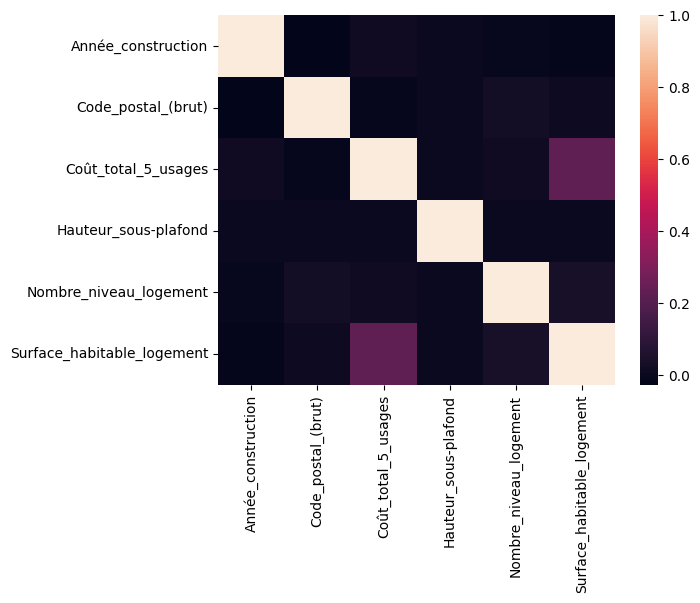

In [27]:
import seaborn as sns

data_quanti = pd.concat([quanti_train, quanti_test])
data_y = pd.concat([y_train, y_test])
data = pd.concat([data_quanti, data_y], axis=1)
sns.heatmap(data_quanti.corr())

On peut observer qu'il y a peu de corrélation entre les variables

C:\Users\Evidya\AppData\Local\Temp\ipykernel_19044\795679054.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Etiquette_DPE', data=data, palette='Set3')


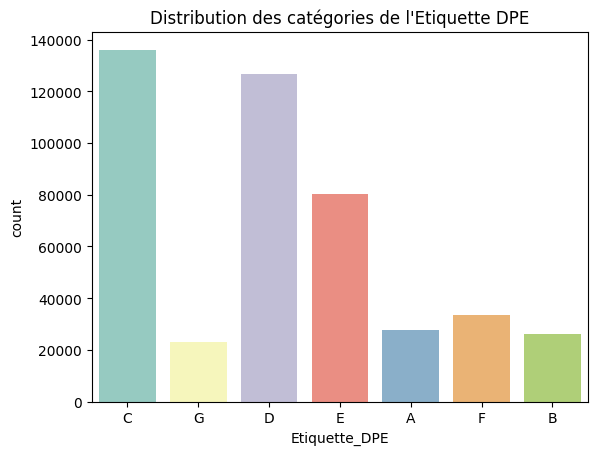

In [32]:
import matplotlib.pyplot as plt

sns.countplot(x='Etiquette_DPE', data=data, palette='Set3')
plt.title('Distribution des catégories de l\'Etiquette DPE')
plt.show()

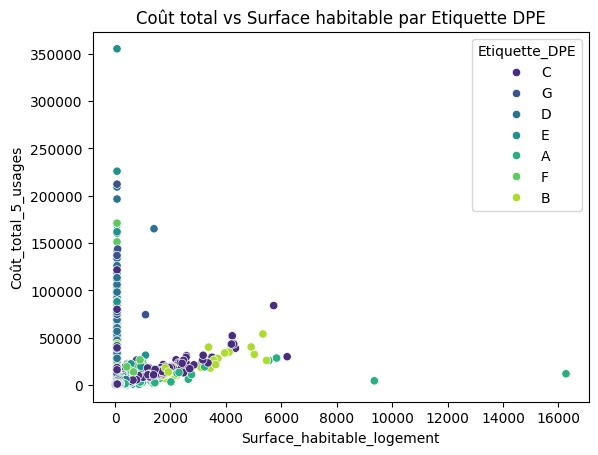

In [33]:
sns.scatterplot(x='Surface_habitable_logement', y='Coût_total_5_usages', hue='Etiquette_DPE', data=data, palette='viridis')
plt.title('Coût total vs Surface habitable par Etiquette DPE')
plt.show()


Lorsqu'on croise le Coût total et la Surface habitable par Etiquette DPE, on observe une sorte de corrélation qui semble croissante. Cela peut suggérer que les logements plus grands tendent à avoir des coûts énergétiques plus élevés. Ce qui semble tout à fait normal car une plus grande surface nécessite souvent plus d’énergie pour le chauffage, la climatisation, et autres usages, ce qui augmente le coût énergétique global.

## Modèle de classification 

In [34]:
def to_drop_before_model(case="classification"):
    if case=="classification":
        return ["Adresse_brute","Code_INSEE_(BAN)", "Date_fin_validité_DPE", "Date_réception_DPE", 
           "Date_visite_diagnostiqueur", "Date_établissement_DPE", "Identifiant__BAN", "N°DPE", "_geopoint"]
    elif case=="regression":
        return []
    else:
        print("Error. Only 'classification' or 'regression' supported")
        return
    

to_drop = to_drop_before_model(case="classification")



def chunking_MCA(quali_train, quali_test, n_components, n_iter, seed, chunk_size):
    # Exportation en csv pour le chunking
    quali_train.to_csv(os.path.join('data','processed','quali_train.csv'), index=False, sep=";", encoding="utf-8-sig")
    quali_test.to_csv(os.path.join('data','processed','quali_test.csv'), index=False, sep=";", encoding="utf-8-sig")

    import prince

    mca = prince.MCA(
        n_components=n_components,
        n_iter=n_iter,
        copy=False,
        check_input=False,
        random_state=seed,
        engine="sklearn",
        handle_unknown="error"  # paramètre identique à celui de sklearn.preprocessing.OneHotEncoder
    )

    print("MCA : fitting to train set")
    quali_train_mca_lst = []
    i = 0
    for chunk in pd.read_csv(os.path.join('data','processed','quali_train.csv'), sep=';', chunksize=chunk_size):
        mca = mca.fit(chunk)
        quali_train_mca_lst.append(mca.transform(chunk))
        i += 1
        if i%100==0:
            print((i*chunk_size)/quali_train.shape[0])
    
    quali_train_mca = pd.DataFrame()
    for elem in quali_train_mca_lst:
        quali_train_mca = pd.concat([quali_train_mca, pd.DataFrame(elem)], axis=0, ignore_index=True)

    print("MCA : transforming test set")

    quali_test_mca_lst = []
    i = 0
    for chunk in pd.read_csv(os.path.join('data','processed','quali_test.csv'), sep=';', chunksize=chunk_size):
        quali_test_mca_lst.append(mca.transform(chunk))
        i += 1
        if i%50==0:
            print((i*chunk_size)/quali_test.shape[0])
    
    quali_test_mca = pd.DataFrame()
    for elem in quali_test_mca_lst:
        quali_test_mca = pd.concat([quali_test_mca, pd.DataFrame(elem)], axis=0, ignore_index=True)
    
    os.remove(os.path.join('data','processed','quali_train.csv'))
    os.remove(os.path.join('data','processed','quali_test.csv'))

    return quali_train_mca, quali_test_mca


quali_train_mca, quali_test_mca =  chunking_MCA(quali_train, quali_test, n_components=10, n_iter=10, seed=0, chunk_size=1000)

def merge_type_back(quali_train_mca, quali_test_mca, quanti_train, quanti_test, train_index, test_index):
    # Convert colnames to str
    quali_train_mca.columns = quali_train_mca.columns.astype(str)
    quali_test_mca.columns = quali_test_mca.columns.astype(str)

    quali_train_mca.set_index(train_index, inplace=True)
    quali_test_mca.set_index(test_index, inplace=True)

    # Concaténer, quali_train et quanti_train de même avec test
    X_train_mca = pd.concat([quanti_train, quali_train_mca], axis=1)
    X_test_mca = pd.concat([quanti_test, quali_test_mca], axis=1)

    return X_train_mca, X_test_mca

X_train_mca, X_test_mca = merge_type_back(quali_train, quali_test, quanti_train, quanti_test, X_train.index, X_test.index)

MCA : fitting to train set
0.31497848696934
0.62995697393868
0.9449354609080199
MCA : transforming test set
0.36747142909638775
0.7349428581927755


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_mca_scaled = pd.DataFrame(scaler.fit_transform(X_train_mca), index=X_train_mca.index, columns=X_train_mca.columns)
X_test_mca_scaled = pd.DataFrame(scaler.transform(X_test_mca), index=X_test_mca.index, columns=X_test_mca.columns)


### Feature selection

markdown

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0, verbose=1)
rf.fit(X_train_mca, y_train)
y_pred = rf.predict(X_test_mca)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s


In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8291
           B       0.92      0.90      0.91      7865
           C       0.94      0.98      0.96     40854
           D       0.91      0.90      0.91     38068
           E       0.89      0.87      0.88     24065
           F       0.86      0.84      0.85     10011
           G       0.90      0.82      0.86      6911

    accuracy                           0.92    136065
   macro avg       0.91      0.90      0.90    136065
weighted avg       0.91      0.92      0.91    136065



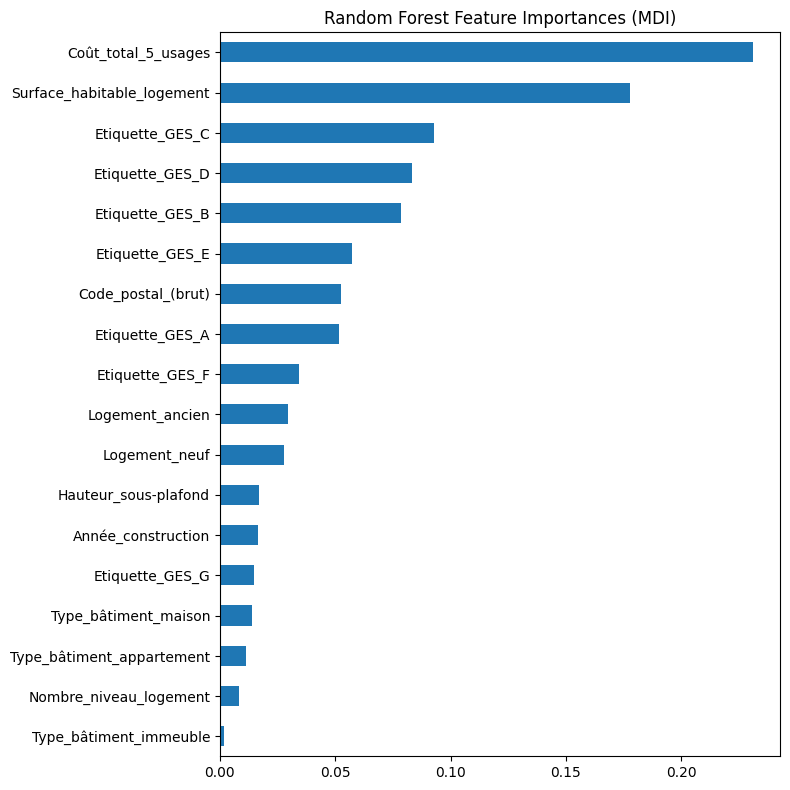

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_[:20]

mdi_importances = pd.Series(
    rf.feature_importances_[:20], index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

In [40]:
vars = feature_names
vars

array(['Année_construction', 'Code_postal_(brut)', 'Coût_total_5_usages',
       'Hauteur_sous-plafond', 'Nombre_niveau_logement',
       'Surface_habitable_logement', 'Etiquette_GES_A', 'Etiquette_GES_B',
       'Etiquette_GES_C', 'Etiquette_GES_D', 'Etiquette_GES_E',
       'Etiquette_GES_F', 'Etiquette_GES_G', 'Logement_ancien',
       'Logement_neuf', 'Type_bâtiment_appartement',
       'Type_bâtiment_immeuble', 'Type_bâtiment_maison'], dtype=object)

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8291
           B       0.91      0.90      0.90      7865
           C       0.94      0.97      0.96     40854
           D       0.90      0.90      0.90     38068
           E       0.88      0.86      0.87     24065
           F       0.84      0.82      0.83     10011
           G       0.87      0.81      0.84      6911

    accuracy                           0.91    136065
   macro avg       0.90      0.89      0.89    136065
weighted avg       0.91      0.91      0.91    136065



In [ ]:
new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":200,
                     "Coût_total_5_usages":10000,
                     "Etiquette_GES":"B",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

Pour cet exemple de données, le modèle de classification a prédit **l'étiquette E**.

## Modèle de regression

In [ ]:
df = pd.read_csv(os.path.join('data','processed','data_classification.csv'), sep=";")